In [63]:
# %%
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math
import numba
import matplotlib.cm as cm
from scipy.sparse import csr_matrix
from Solver import Solve
# %%
%load_ext autoreload
%autoreload 2


# Define the range
r = 0.5
theta_min = 0
theta_max = 3*math.pi/2

# signal= theta_node (theta_max-theta_node), np.sin(theta_node (theta_max-theta_node))

length=600
# Create a grid graph
G = nx.grid_2d_graph(length,length)
# Create positions for each node
pos = {(x,y):(8*x/length-4, 8*y/length-4) for x,y in G.nodes()}


Sub_nodes = []
perimter_nodes = []
for node in list(G.nodes()):  # Use list(G.nodes()) to create a copy of the nodes list, because you can't modify a list while iterating over it
    x, y = pos[node]
    r_node, theta_node = math.sqrt(x**2 + y**2), np.select([y>=0,y<0],[np.arctan2(y,x),np.arctan2(y,x)+2*math.pi,])   
    if r_node <= r and theta_min <= theta_node <= theta_max:      
        Sub_nodes.append(node)
    elif G.degree(node) < 4:
        perimter_nodes.append(node)    

# Create the subgraph
Sub_G = G.subgraph(Sub_nodes)

# Create a dictionary for the signals
signals = {}

# Calculate the signals
subgraph_pos = {node: pos[node] for node in Sub_G.nodes()}  # Get the positions of the nodes in the subgraph

internal_nodes=[]
boundary_nodes=[]
for node in Sub_G.nodes():
    x, y = subgraph_pos[node]
    if Sub_G.degree(node) < 4:
        theta_node = np.select([y>=0,y<0],[np.arctan2(y,x),np.arctan2(y,x)+2*math.pi,]) 
        r_node = math.sqrt(x**2 + y**2)
        if 0.000001*theta_max+theta_min <= theta_node <= theta_max-0.000001*theta_max and r_node>r*0.7 :
            signals[node] = theta_node*(theta_max-theta_node)*np.sin(5*theta_node*(theta_max-theta_node))
            boundary_nodes.append(node)
        else:
            signals[node] = 0
            boundary_nodes.append(node)
    else:
        internal_nodes.append(node)

for i in perimter_nodes:
    signals[i] = 0

# Get the signal values
node_colors = [signals.get(node, 0) for node in Sub_G.nodes()]  # Use 0 for nodes that were not assigned a signal

bound_G_nodes = set(G.nodes()) - set(internal_nodes) 
bound_G = G.subgraph(bound_G_nodes)
# Create a new position dictionary for bound_G
bound_G_pos = {node: pos[node] for node in bound_G.nodes()}

# Assume node_to_index is a dictionary that maps nodes to their indices
node_to_index = {node: index for index, node in enumerate(bound_G.nodes())}

# Create an array of boundary nodes indices in U
bounds = np.array([node_to_index[node] for node in boundary_nodes+perimter_nodes])

# Calculate the Laplacian matrix of bound_G
L = nx.laplacian_matrix(bound_G)

node_to_index = {node: i for i, node in enumerate(bound_G.nodes())}
x_bound = []

for i in boundary_nodes+perimter_nodes:
    x_bound.append(signals[i]) 

x_bound = np.array(x_bound)

# %%


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:

U,loss=Solve(x_bound,bounds, L, alpha=10, learning_rate=0.5, num_iter=50000, verbose=False, convergence_threshold=1e-9,loss=True)


Did not converge after 50000 iterations with loss: 30.035126111944766


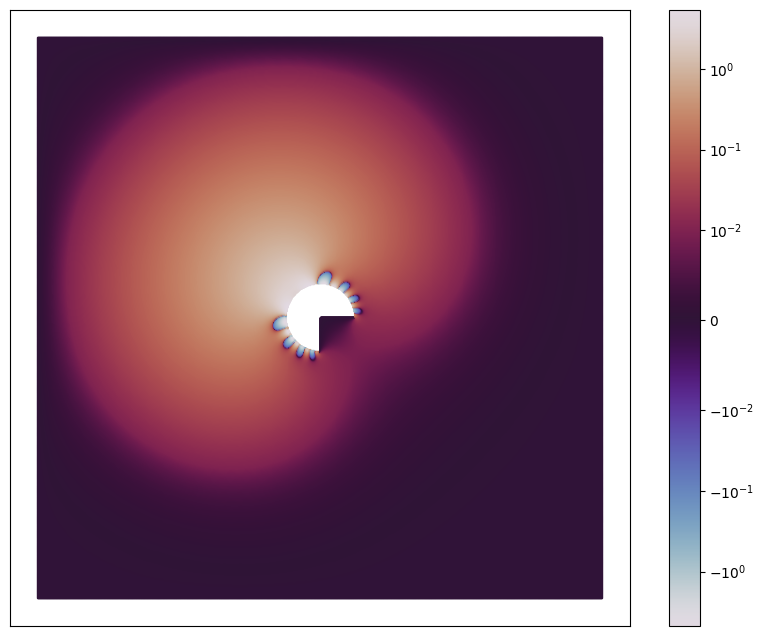

In [82]:
import matplotlib.colors as colors
import numpy as np

# Create a new figure with specified size (width, height)
fig, ax = plt.subplots(figsize=(10, 8))

# Create a SymLogNorm object
norm = colors.SymLogNorm(linthresh=0.01)

# Normalize the node colors
node_colors = norm(U)

# Draw the nodes with normalized colors
cc = nx.draw_networkx_nodes(bound_G, pos=bound_G_pos, node_color=node_colors, node_size=1, cmap=plt.cm.twilight)

# Create a new scalar mappable
sm = plt.cm.ScalarMappable(cmap=cc.cmap, norm=norm)
sm.set_array([])

# Add the color bar
plt.colorbar(sm, ax=ax)


# Show the plot
plt.show()

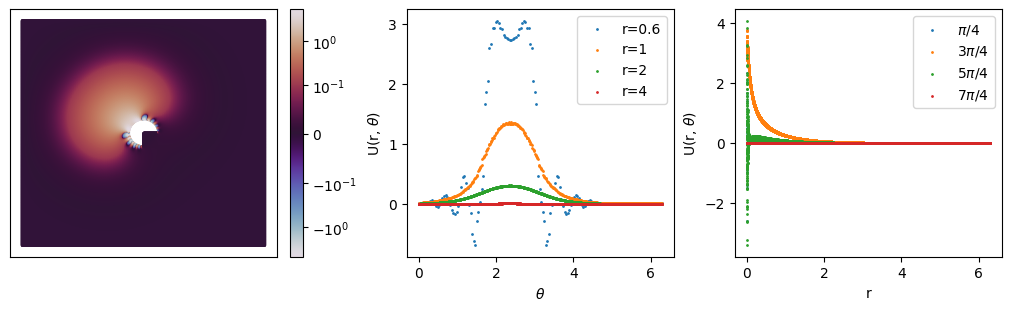

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.colors as colors

# Assuming U, bound_G, and bound_G_pos are defined

fig, axs = plt.subplots(1, 3, figsize=(10,3),layout='constrained')

# First subplot
norm = colors.SymLogNorm(linthresh=0.1, vmin=U.min(), vmax=U.max(), base=10)
# Apply normalization to U for color mapping
node_colors = norm(U)
# Convert normalized colors to actual colors for display
node_colors_mapped = plt.cm.twilight(node_colors)
# Now draw with the mapped colors
cc = nx.draw_networkx_nodes(bound_G, pos=bound_G_pos, node_color=node_colors_mapped, node_size=1, ax=axs[0])
# Setup colorbar properly
sm = plt.cm.ScalarMappable(cmap=plt.cm.twilight, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=axs[0])

xy = np.array(list(bound_G_pos.values()))
radii_array = np.sqrt(np.sum(xy**2, axis=1))
thetas_array = np.arctan2(xy[:, 1], xy[:, 0]) % (2 * np.pi)

# Corrected radius loop
radii_values = [0.6, 1, 2, 4]
for radii in radii_values:
    mask_r = (0.99 * radii <= radii_array) & (radii_array <= 1.001 * radii)
    if np.any(mask_r):  # Only plot if any values are within the range
        theta_sorted_indices = np.argsort(thetas_array[mask_r])
        axs[1].scatter(np.linspace(0, 2*np.pi, np.sum(mask_r)), U[mask_r][theta_sorted_indices], s=1, label=f'r={radii}')
axs[1].set_ylabel(r'U(r, $\theta$)')
axs[1].set_xlabel(r'$\theta$')
axs[1].legend()

# Corrected theta loop
theta_values = [np.pi/4, 3*np.pi/4, 5*np.pi/4, 7*np.pi/4]
labels = [r'$\pi/4$', r'$3\pi/4$', r'$5\pi/4$', r'$7\pi/4$']
for theta, label in zip(theta_values, labels):
    mask_theta = (0.9 * theta <= thetas_array) & (thetas_array <= 1.1 * theta)
    if np.any(mask_theta):  # Only plot if any values are within the range
        radius_sorted_indices = np.argsort(radii_array[mask_theta])
        axs[2].scatter(np.linspace(0, 2*np.pi, np.sum(mask_theta)), U[mask_theta][radius_sorted_indices], s=1, label=label)
axs[2].set_ylabel(r'U(r, $\theta$)')
axs[2].set_xlabel('r')
axs[2].legend()
plt.savefig('U(r,theta).png')
plt.show()


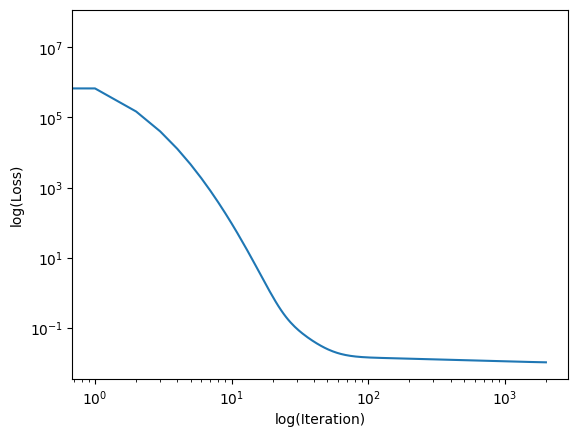

In [15]:
plt.plot(((loss[2:2000])))
plt.yscale('log')  # Set the y-axis to a logarithmic scale
plt.xscale('log')  # Set the x-axis to a logarithmic scale
plt.xlabel('log(Iteration)')
plt.ylabel('log(Loss)')
plt.savefig("loss.png", format='png')
plt.show()